# ทดสอบรวมฝนรายชั่วโมงเป็นฝนรายวัน ใช้คอลัมน์ full_date และ code พลอต density ใช้ ZR MP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## read cleansing 

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df
#df.head()

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


### คำนวน rain estimates จาก ZRs

In [4]:
### ZR marshall/palmer
a=200. 
b=1.6
df['rr_MP_c1']=((10**(df['dBZ_c1']/10.))/a)**(1/b)
df['rr_MP_c2']=((10**(df['dBZ_c2']/10.))/a)**(1/b)
df['rr_MP_c3']=((10**(df['dBZ_c3']/10.))/a)**(1/b)
df['rr_MP_c4']=((10**(df['dBZ_c4']/10.))/a)**(1/b)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0,1.273687,1.186179,0.656222,0.711362
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0,1.396314,1.077049,1.065285,1.188544
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820252,1.820251
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0,0.970859,1.195389,1.691887,2.039476
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0,0.711009,0.687794,0.622425,0.578014
...,...,...,...,...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0,0.403353,0.330749,0.249307,0.205053
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2,1.257301,1.274637,1.205704,1.054208
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0,4.020371,3.615000,3.460884,2.943195
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0,1.758216,1.745019,0.519070,1.044052


In [5]:
## ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,2018-06-01-00:00,CMSG,0.0,1.273687,1.186179,0.656222,0.711362
1,2018-06-01-00:00,KGTP,0.0,1.396314,1.077049,1.065285,1.188544
2,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820252,1.820251
3,2018-06-01-00:00,NAN011,0.0,0.970859,1.195389,1.691887,2.039476
4,2018-06-01-00:00,SLBC,0.0,0.711009,0.687794,0.622425,0.578014
...,...,...,...,...,...,...,...
8656,2018-09-21-16:00,TPKO,0.0,0.403353,0.330749,0.249307,0.205053
8657,2018-09-21-17:00,CNDN,0.2,1.257301,1.274637,1.205704,1.054208
8658,2018-09-21-17:00,NAN005,0.0,4.020371,3.615000,3.460884,2.943195
8659,2018-09-21-17:00,NGBA,0.0,1.758216,1.745019,0.519070,1.044052


### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพือ่ใช้ร่วมกับคอลัมน์ code

In [6]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

# The resulting DataFrame 'aggregated_data' will have the aggregated values
print(aggregated_data)

       date_only    code  rain_truth   rr_MP_c1   rr_MP_c2   rr_MP_c3  \
0     2018-06-01    BPPS         0.2   1.863638   1.637148   1.805962   
1     2018-06-01    CMSG         4.8  15.745538  14.514371  14.206068   
2     2018-06-01    CNDN         0.0   5.869510   6.950422   4.116697   
3     2018-06-01  DIV003         0.0   3.071936   2.678807   2.777564   
4     2018-06-01  DIV005         0.0   0.712271   0.714967   0.911959   
...          ...     ...         ...        ...        ...        ...   
1955  2018-09-21  NAN008         0.0   0.658036   0.658036   0.658036   
1956  2018-09-21    NGBA         0.0   1.758216   1.745019   0.519070   
1957  2018-09-21  PIN003         2.4  24.963777  25.235654  21.223118   
1958  2018-09-21    TGSK         0.0   1.158313   1.102891   1.155236   
1959  2018-09-21    TPKO         0.0   0.403353   0.330749   0.249307   

       rr_MP_c4  
0      2.206973  
1     15.196123  
2      3.348057  
3      2.623048  
4      1.092430  
...         ...

In [7]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_MP_c1']>0]

In [8]:
df_.reset_index(drop=True, inplace=True)

In [9]:
df_.describe()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
count,961.000000,961.000000,961.000000,961.000000,961.000000
mean,6.129448,11.385044,11.207611,11.210664,11.067666
std,9.208948,13.389724,12.443678,12.033307,12.245483
min,0.200000,0.177591,0.169650,0.187247,0.166486
25%,0.400000,3.753066,3.757482,3.705922,3.806149
50%,2.000000,6.954112,7.172705,7.571260,7.541627
75%,7.800000,13.060170,13.937973,14.265413,13.577596
max,77.800000,108.148532,113.156216,118.655361,169.342932


In [10]:
df_.corr()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
rain_truth,1.000000,0.549744,0.559747,0.588649,0.522502
rr_MP_c1,0.549744,1.000000,0.949216,0.855118,0.716186
rr_MP_c2,0.559747,0.949216,1.000000,0.924800,0.777167
rr_MP_c3,0.588649,0.855118,0.924800,1.000000,0.923067
rr_MP_c4,0.522502,0.716186,0.777167,0.923067,1.000000


## พลอต scatter คำนวณสถิติ และ พลอตค่า metrics

In [11]:
def density_plot(rain_truth, rain_radar):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')
    plt.legend()

    # Display the plot
    plt.show()


RMSE: 12.490166049824515
MSE: 156.00424795218893
MAE: 7.701075204774146
R-squared: 0.12894553980379375
Correlation coefficient (r): 0.5497443065852334
P-value: 5.4088632056889256e-77


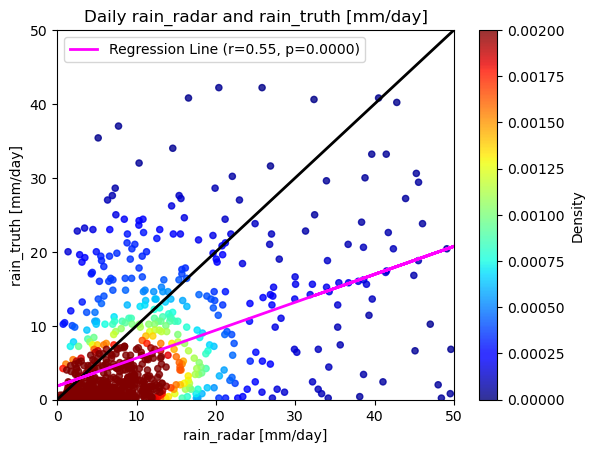

In [12]:
density_plot(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 11.706210164941737
MSE: 137.03535642578524
MAE: 7.333256262341555
R-squared: 0.11409473101551137
Correlation coefficient (r): 0.5597468120993877
P-value: 2.4363430359044583e-80


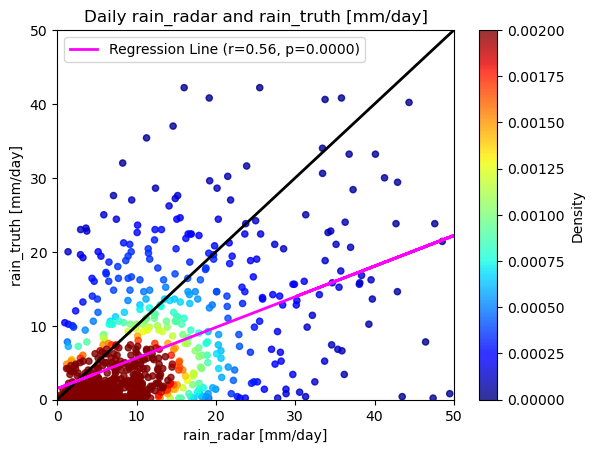

In [13]:
density_plot(df_['rain_truth'],df_['rr_MP_c2'])

RMSE: 11.174053715091382
MSE: 124.85947642774754
MAE: 7.250215880139728
R-squared: 0.13681545772995474
Correlation coefficient (r): 0.58864941805631
P-value: 1.1165570462883882e-90


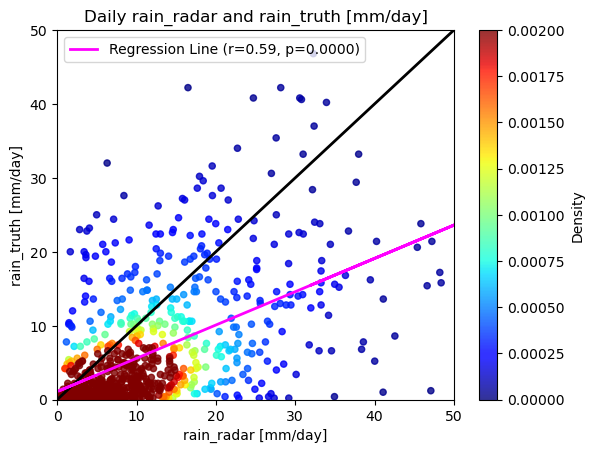

In [14]:
density_plot(df_['rain_truth'],df_['rr_MP_c3'])

RMSE: 11.881825480560224
MSE: 141.1777767504902
MAE: 7.451583631133239
R-squared: 0.057531910366908856
Correlation coefficient (r): 0.5225024937079933
P-value: 1.9717290759195563e-68


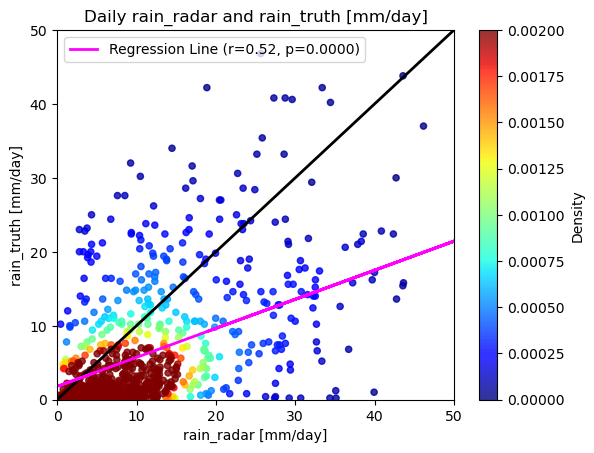

In [15]:
density_plot(df_['rain_truth'],df_['rr_MP_c4'])

### คำนวณสถิติ และ พลอตค่า metrics

In [16]:
def density_plot_joint(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')
    
    max_=50

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


RMSE: 12.490166049824516
MSE: 156.00424795218896
MAE: 7.701075204774146
R-squared: 0.12894553980379364
Correlation coefficient (r): 0.549744306585233
P-value: 5.4088632056910825e-77


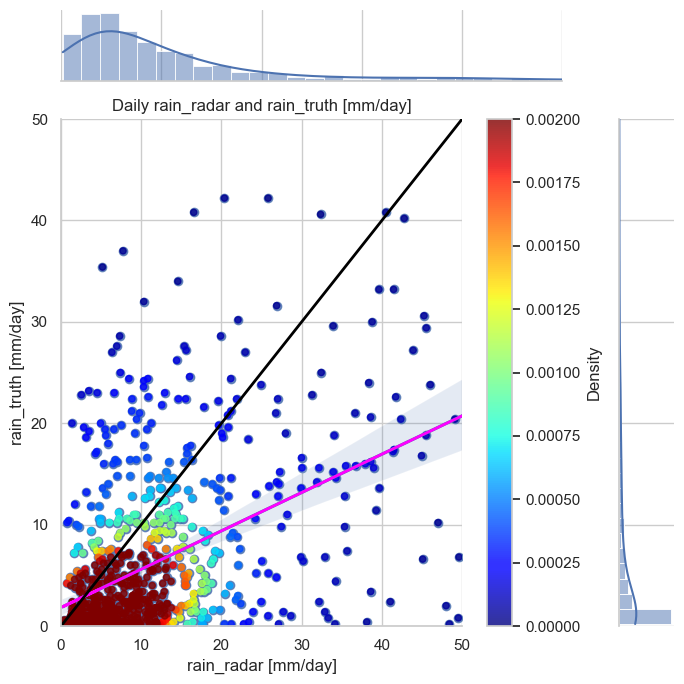

In [17]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 11.706210164941737
MSE: 137.03535642578524
MAE: 7.333256262341555
R-squared: 0.11409473101551115
Correlation coefficient (r): 0.5597468120993871
P-value: 2.4363430359056384e-80


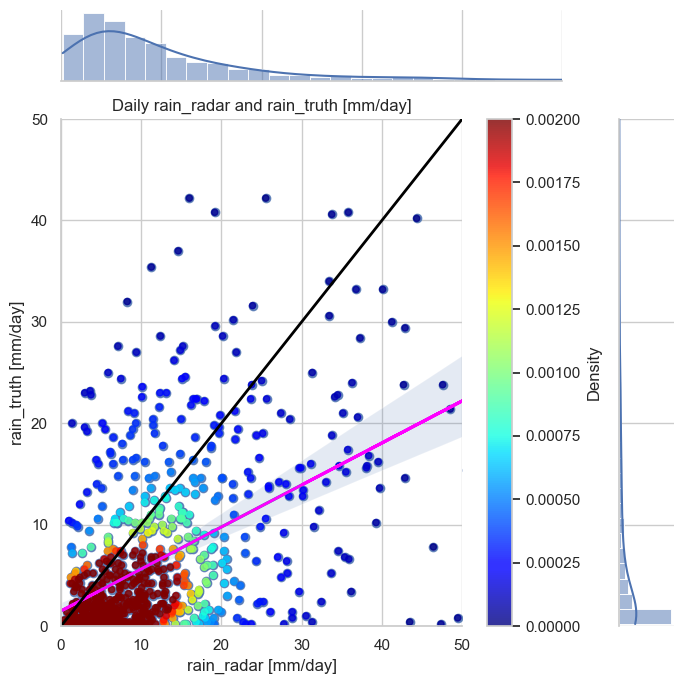

In [18]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c2'])

RMSE: 11.174053715091384
MSE: 124.85947642774757
MAE: 7.250215880139727
R-squared: 0.13681545772995463
Correlation coefficient (r): 0.5886494180563089
P-value: 1.116557046289501e-90


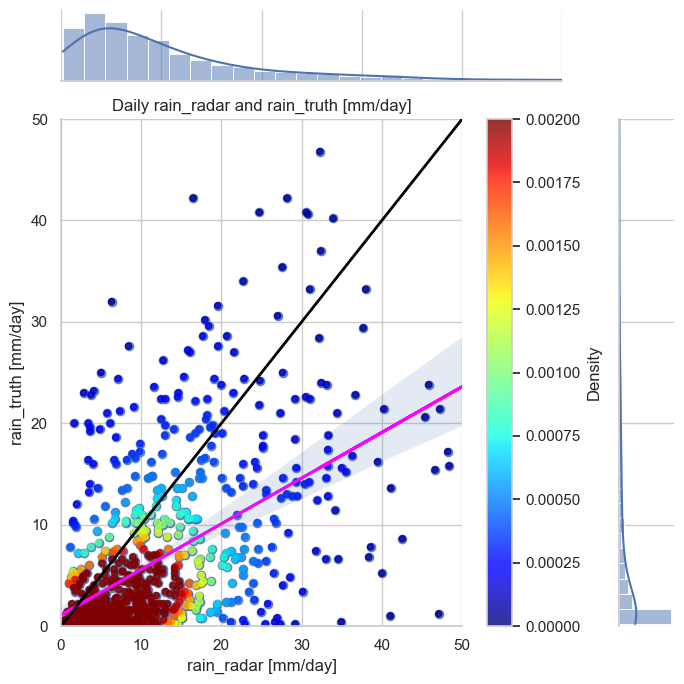

In [19]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c3'])

RMSE: 11.881825480560224
MSE: 141.1777767504902
MAE: 7.451583631133238
R-squared: 0.057531910366908856
Correlation coefficient (r): 0.5225024937079933
P-value: 1.9717290759195563e-68


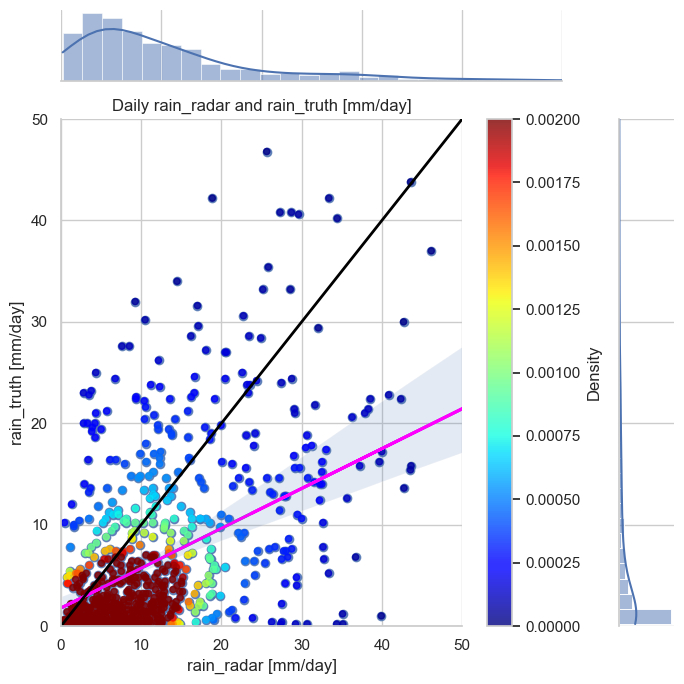

In [20]:
density_plot_joint(df_['rain_truth'],df_['rr_MP_c4'])

## รวมฝนรายวันเป็นฝนทั้งเหตุการณ์ของแต่ละสถานี

In [21]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [22]:
df_

,date_only,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,2018-06-01,BPPS,0.2,1.863638,1.637148,1.805962,2.206973
1,2018-06-01,CMSG,4.8,15.745538,14.514371,14.206068,15.196123
2,2018-06-01,KGKG,0.4,4.247434,4.523870,5.118124,4.913026
3,2018-06-01,KGLN,0.2,9.525199,9.383426,8.891101,10.005087
4,2018-06-01,KOKO,19.4,5.499681,8.936829,14.036789,12.139208
...,...,...,...,...,...,...,...
956,2018-09-20,TGSK,1.0,3.771289,4.169397,4.860713,5.157778
957,2018-09-20,TSLM,1.0,1.762612,1.753607,1.730858,1.612333
958,2018-09-20,VLGE15,0.4,2.769049,2.665906,2.546710,2.415184
959,2018-09-21,CNDN,0.2,1.760339,1.737838,1.689254,1.555727


In [23]:
import pandas as pd

# Assuming df_ is your DataFrame
# Group by 'code' and calculate the mean for each group
aggregated_df = df_.groupby('code').mean().reset_index()

# Display the aggregated DataFrame
print("Aggregated DataFrame:")
df_=aggregated_df
print(df_)


Aggregated DataFrame:
      code  rain_truth   rr_MP_c1   rr_MP_c2   rr_MP_c3   rr_MP_c4
0     BDLH    6.684211   8.287096   7.388384   7.498771   7.056984
1     BMNK    1.000000   4.656553   3.357731   4.842421   3.390141
2     BPPS    5.626667  12.420416  11.548746  10.935818  10.401998
3     CMSG    6.500000  14.323385  13.216590  11.406287  10.199655
4     CNDN   11.982609  20.244779  16.557053  15.317926  14.000860
..     ...         ...        ...        ...        ...        ...
63    WSPN    4.608696   7.068902   8.194225   8.133239   8.450843
64  YOM005    5.400000  16.892954  16.708811  15.954913  15.672322
65  YOM006    4.323077   8.020158   7.630160   8.575317   8.542387
66  YOM009    6.740000  12.176063  11.239828  10.943170  11.234252
67  YOM012    0.400000   4.930074   3.845009   4.584618   4.916232

[68 rows x 6 columns]


In [24]:
df_.corr()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
rain_truth,1.000000,0.486934,0.419643,0.428397,0.424340
rr_MP_c1,0.486934,1.000000,0.890206,0.755771,0.660124
rr_MP_c2,0.419643,0.890206,1.000000,0.941477,0.837706
rr_MP_c3,0.428397,0.755771,0.941477,1.000000,0.948983
rr_MP_c4,0.424340,0.660124,0.837706,0.948983,1.000000


RMSE: 7.406023983207235
MSE: 54.84919123984076
MAE: 5.931859209554115
R-squared: -0.8576594752661557
Correlation coefficient (r): 0.48693353541142625
P-value: 2.545683128060975e-05


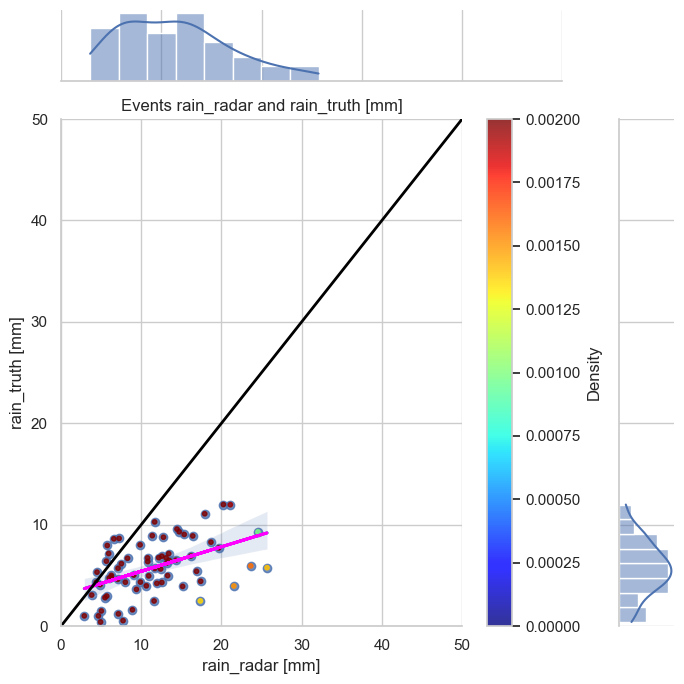

In [25]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 7.745609411049732
MSE: 59.99446514854218
MAE: 5.794828296038725
R-squared: -0.803042709473442
Correlation coefficient (r): 0.419643010960655
P-value: 0.0003676746441520824


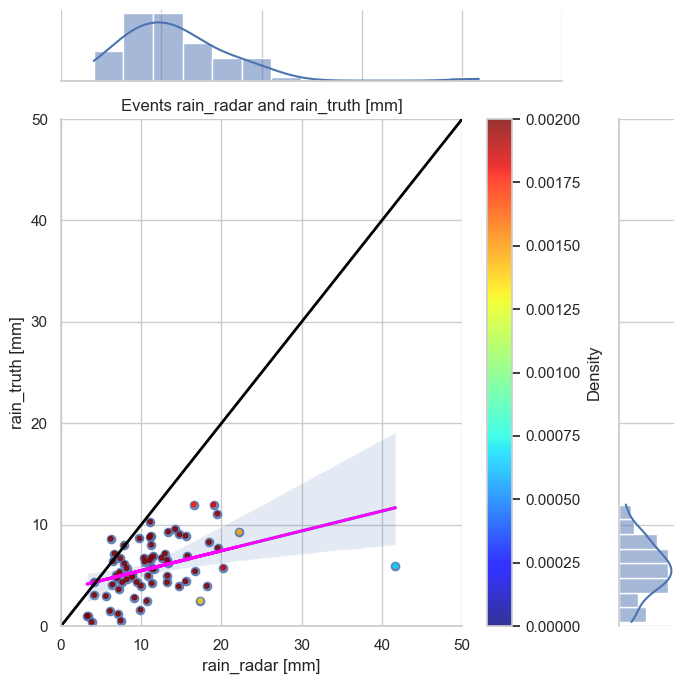

In [26]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c2'])

RMSE: 7.613886990755031
MSE: 57.971275107988696
MAE: 5.784085476134529
R-squared: -0.7841615048783412
Correlation coefficient (r): 0.42839740836539864
P-value: 0.0002678579680627913


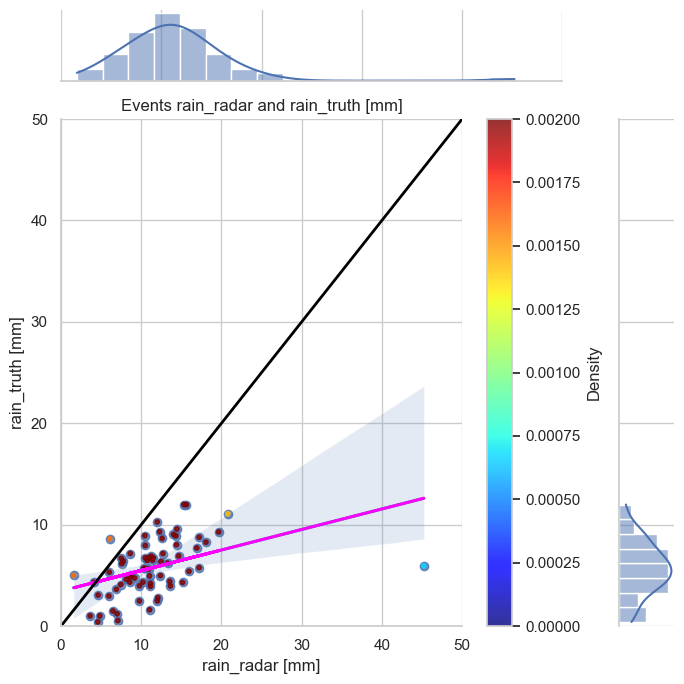

In [27]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c3'])

RMSE: 7.08788368524264
MSE: 50.23809513552879
MAE: 5.412812018138432
R-squared: -0.8447620496034105
Correlation coefficient (r): 0.424339605704317
P-value: 0.00031054804398504153


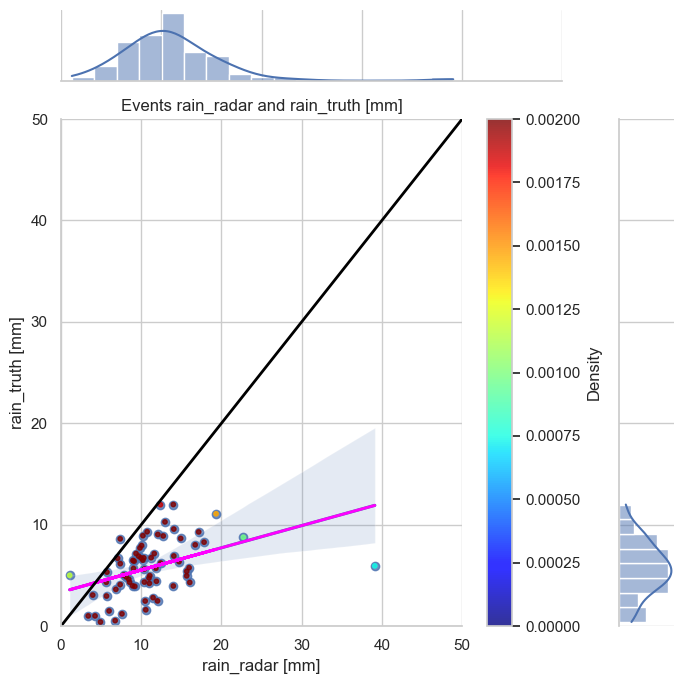

In [28]:
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c4'])

## หา bias และปรับแก้แบบ MFB Mean Field Bias Correction